<div style="display: flex; align-items: center; justify-content: space-between; width: 100%;"> <div style="flex: 1; text-align: left;"> <img src="Imagens/logo_ufcg.png" alt="Logo UFCG" style="height: 100px;"> </div> <div style="flex: 2; text-align: center;"> <p style="font-size: 16px; font-weight: bold; margin: 0; line-height: 1.5;"> UNIVERSIDADE FEDERAL DE CAMPINA GRANDE<br> CENTRO DE CIÊNCIAS E TECNOLOGIA<br> CENTRO DE ENGENHARIA ELÉTRICA E INFORMÁTICA<br> CENTRO DE COMPETÊNCIAS EMBRAPII VIRTUS-CC </p> </div> <div style="flex: 1; text-align: right;"> <img src="Imagens/logo_virtus2.png" alt="Logo VIRTUS" style="height: 80px;"> </div> </div>




# Sumário

1. [Introdução](#intro)

2. [Desenvolvimento](#desenv)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1 [Fundamentação teórica](#fundament) 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1.1 [Convolução](#convolution)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1.2 [Complexidade Computacional](#complexidade)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1.3 [Equações de diferenças](#difeq)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1.4 [Amostragem de sinais contínuos no tempo](#amostragem)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1.5 [Ruído aditivo gaussiano branco](#awgn)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2 [Materiais e método](#materiais)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2.1 [Convolução](#221-convolução)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2.2 [Complexidade computacional](#222-complexidade-computacional)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2.3 [Equações de diferenças](#223-equações-de-diferenças)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2.4 [Amostragem de sinais contínuos no tempo](#224-amostragem-de-sinais-contínuos-no-tempo)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2.5 [Ruído aditivo gaussiano branco](#225-ruído-aditivo-gaussiano-branco)

3. [Resultados e discussões](#3-resultados-e-discussões)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1 [Convolução](#31-convolução)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2 [Complexidade Computacional](#32-complexidade-computacional)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3 [Equações de diferenças](#33-equações-de-diferenças)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.4 [Amostragem de sinais contínuos no tempo](#34-amostragem-de-sinais-contínuos-no-tempo)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.5 [Ruído aditivo gaussiano branco](#35-ruído-aditivo-gaussiano-branco)

4. [Conclusão](#conclusao)



<a id="intro"></a>
# Introdução

A convolução é uma operação muito utilizada em processamento de sinais, pois ela permite que a saída de qualquer sistema linear a uma entrada qualquer seja obtida a partir da resposta ao impulso desse sistema, de modo que não seja necessário compreender o funcionamento do sistema internamente. Contudo, o algoritmo de soma de convolução é computacionalmente exigente em termos de tempo de processamento. A complexidade computacional de um algoritmo está diretamente relacionada à quantidade de operações que são realizadas, e log, ao seu tempo de execução. No contexto de processamento digital, esse é um fator crucial no projeto, pois todas as operações devem ser realizadas no tempo hábil referente ao intervalo entre símbolos, para que o sistema possa operar em tempo real. Neste relatório, é contemplado o algoritmo da soma de convolução em linguagem de alto nível, utilizada para fase de prototipagem inicial em projetos de sistemas embarcados ou de hardware dedicado para processamento digital de sinais, sua complexidade computacional é analisada, bem como são investigadas técnicas de otimização e aceleração de código para o algoritmo de convolução. O relatório também contempla conceitos introdutórios para o processamento digital de sinais, como equações de diferenças, e amostragem.

<a id="desenv"></a>
# 2. Desenvolvimento

<a id="funtament"></a>
## 2.1 Fundamentação teórica

<a id="convolution"></a>
### 2.1.1 Convolução

Admita um sinal discreto arbitrário $x(n)$ e um sistema discreto linear e invariante no tempo caracterizado por sua resposta ao impulso $h(n)$. A saída temporal $y(n)$ desse sistema quando $x(n)$ é aplicado à sua entrada pode ser obtida através da operação de convolução discreta entre $x(n)$ e $h(n)$. A expressão matemática da convolução discreta é dada por:

$$
y(n) = \sum _{k = -\infty}^\infty x(k) h(n-k)\tag{2.1}
$$

Vale salientar que em sistemas físicos e digitais reais, os sinais são frequentemente finitos, e a soma de convolução é computada sobre um intervalo limitado. Assim, dado um sinal de entrada com $N $ amostras e uma resposta ao impulso  com $M$ amostras, a eq.(2.1) se torna:

$$
    y(n) = \sum _{k = 0}^{M-1} x(k) h(n-k)\tag{2.2}
$$

Esse somatório é realizado para cada valor de $n$, gerando uma saída $y(n)$ com $N + M -1$ amostras.

<a id="complexidade"></a>
### 2.1.2 Complexidade computacional

A complexidade computacional de um algoritmo refere-se à quantidade de recursos computacionais — como tempo de execução ou memória — necessários para realizar uma tarefa em função do tamanho da entrada. No caso da convolução discreta, o recurso mais crítico é o tempo de processamento, que depende diretamente do número de operações aritméticas realizadas.

No caso da soma de convolução descrita na eq.(2.2), para cada valor de $y(n)$, são realizadas $M$ multiplicações e $M-1$ somas. Assim, no total, há $M \cdot (N+N-1)$ multiplicações e $(M-1)\cdot (N+M-1)$ adições. 

Uma ferramenta matemática utilizada para descrever o comportamento de um algoritmo para tamanhos de entrada muito grandes é a ordem de complexidade assintótica. Ela mostra como o tempo de execução de um algoritmo cresce com relação ao tamanho da entrada. A notação Big-O utilizada representa o limite superior  da taxa de crescimento, ignorando termos de menor ordem, e foca apenas no termo dominante, que mais influencia na variação do tempo de execução.

No caso da convolução discreta, o maior fator que influencia na quantidade de operações realizadas é proporcional a $M\cdot N$, de modo que, tomando $N \approx M$, a complexidade é: $O(N^2)$. Ou seja, o tempo de execução cresce quadraticamente  com o tamanho do sinal de entrada.

<a id="difeq"></a>
### 2.1.3 Equações de diferenças

Um sistema discreto pode ser representado por uma equação de diferenças, que descreve a relação entre a entrada $x(n)$ e a saída $y(n)$ do sistema, semelhante à forma como equações diferenciais descrevem sistemas contínuos no tempo. Essa representação é amplamente utilizada na modelagem de sistemas lineares e invariantes no tempo, especialmente em contextos de filtragem digital e controle.

Segundo Gal \& Roberts (1980), uma equação de diferenças genérica de ordem $N$ pode ser expressa como:

$$
    \sum_{i = 0}^N a_i y(n-i) - \sum_{l = 0}^N b_l x(n-l) = 0\tag{2.3}
$$

Essa equação admite infinitas soluções para $y(n)$, sendo necessário fornecer $N$ condições iniciais (ou auxiliares) para determinar uma solução única. Isolando o termo de interesse $y(n)$, tem-se:

$$
    a_0y(n) = \sum_{l = 0}^N b_l x(n-l) - \sum_{i = 1}^N a_i y(n-i)\tag{2.4}
$$

Essa forma explícita permite calcular $y(n)$ de maneira recursiva, desde que os coeficientes $a_i$ e $b_i$, o sinal de entrada $x(n)$ e as condições iniciais de $y(n)$ estejam definidos.

<a id="amostragem"></a>
### 2.1.4 Amostragem de sinais contínuos no tempo 

Para que seja possível realizar o processamento digital de um sinal originalmente contínuo, é necessário, a priori, digitalizar esse sinal. Isso é feito por meio da amostragem, que consiste em coletar valores do sinal contínuo $x_a(t)$ em instantes discretos igualmente espaçados, definidos por um intervalo de amostragem $T$. O sinal amostrado é então representado como:

$$
    x(n) = x_a(nT)\tag{2.5}
$$

A partir disso, é possível representar o sinal contínuo amostrado como um trem de impulsos escalados pelas amplitudes das amostras $x(n)$ nos instantes $nT$:

$$
    x_i(t) = \sum_{n = -\infty}^\infty x(n)\delta(t-nT)\tag{2.6}
$$

onde $\delta(t)$ é o impulso unitário de Dirac, definido como:

$$
\begin{cases}
\delta(t) = 0, & t \neq 0,\\
\displaystyle\int_{-\infty}^{\infty}\delta(t)\,\mathrm{d}t = 1
\end{cases}\tag{2.7}
$$


**Tranformada de Fourier do sinal amostrado**

Sabendo que a transformada de Fourier de um sinal contínuo $x(t)$ é dada por:

$$
X(j\omega) = \int_-\infty^\infty x(t)e^{-j\omega t} dt\tag{2.8}
$$

e que a transformada de um produto de sinais no tempo corresponde à convolução de seus espectros no domínio da frequência, podemos escrever a transformada de Fourier do sinal amostrado $x_i(t)$ como:

$$
X_i(j\omega) =
\frac{1}{2\pi}\;X_a(j\omega)\;\ast\;P(j\omega)
=
\frac{1}{2\pi}
\int_{-\infty}^{\infty}
X_a\bigl(j(\omega - \omega')\bigr)\,
P(j\omega')\,
\mathrm{d}\omega'\tag{2.9}
$$

onde $P(j\omega)$ represetna o espectro do trem de impulsos, periódico, com espaçamento igual à frequência de amsotragem $f_s = 1/T$

**Teorema da amostragem**

O teorema da amostragem estabelece que o espectro de um sinal amostrado é periódico com período igual à frequência de amostragem. Ou seja, o espectro original $X_a(j\omega)$ é infinitamente em torno de múltiplos de $f_s$.Para que seja possível reconstruir o sinal contínuo original a partir do sinal amostrado, é necessário que essas réplicas não se sobreponham.

Isso exige que o sinal original seja limitado em banda, com frequência máxima $\Omega$. Cada réplica do espectro ocupa uma faixa de largura $2\Omega$, centrada em múltiplos de $f_s$. Para evitar sobreposição entre réplicas, a frequência de amostragem deve satisfazer:

$$
f_s \geq 2\Omega\tag{2.10}
$$

Essa frequência mínima é conhecida como frequência de Nyquist. Se $f_s < 2\Omega$, ocorre *aliasing*, e o sinal original  não pode ser recuperado.

<a id="amostragem"></a>
### 2.1.5 Ruído aditivo gaussiano branco

Em sistemas de comunicação e processamento digital de sinais, é comum que os sinais desejados sejam corrompidos por ruído --- uma perturbação indesejada que pode comprometer a integridade da informação transmitida ou processada ---. Um dos modelos mais utilizados para representar esse tipo de interferência é o ruído aditivo gaussiano branco (AWGN — *Additive White Gaussian Noise*). Esse modelo assume que o ruído é:


- **Aditivo**: O ruído se soma ao sinal, sem afetar sua estrutura interna;
- **Gaussiano**: Os valores do ruído obedecem à distribuição normal de probabilidade, com média 0 e variância $\sigma^2$:
    $$
        p(n) = \frac{1}{\sqrt{2\pi \sigma^2}}exp(-\frac{n^2}{2\sigma^2})\tag{2.11}
    $$
- **Branco**: As amostras do ruído são estatisticamente independentes entre si, e possui espectro plano, ou seja, sua desnisdade espectral de potência é constante em todas as frequências.


Esse tipo de ruído é amplamente utilizado em simulações e análises teóricas por sua simplicidade e por representar bem o comportamento de diversos ruídos naturais em sistemas físicos, especialmente quando não há correlação temporal entre os valores de ruído.

<a id="materiais"></a>
## 2.2 Materiais e método

Este trabalho foi desenvolvido com base nos conceitos apresentados na bibliografia **Diniz, Silva e Netto (2014)**, que serviu como principal referência teórica para a implementação dos algoritmos e experimentos. Todas as funções foram desenvolvidas em linguagem Python, utilizando o ambiente *VSCode*, com extensão *jupyter notebook* para organização, execução e visualização dos resultados. As seguintes bibliotecas, ou funções das mesmas foram utilizadas:

- numpy
- time
- matplotlib
- math
- numba
- cupy
- scipy

Foi utilizada padronização para as ilustrações *seaborn/v0_8* e semente *np.random.seed(42)* para chamadas de função com elementos aleatórios:

In [2]:
import numpy as np  
import time
import matplotlib.pyplot as plt
from math import ceil
from numba import njit, prange
#import cupy as cp
from scipy.signal import freqz, lfilter

plt.style.use('seaborn-v0_8')
np.random.seed(42)

<a id="221-convolução"></a>
### 2.2.1 Convolução

O algoritmo da soma de convolução foi implementado em duas versões: uma utilizando laços explícitos (*looping*) e outra vetorizada:

In [3]:
def Conv_sum(x, h, mode='full'):
    """
    Função que calcula a convolução linear de dois sinais x e h.

    A convolução retorna um sinal de tamanho (M+N-1). Isso se deve ao fato da convolução deslocar o sinal de N amostras em M amostras, ou seja, o índice do sinal resultante começa em 0, e segue até (N-1)+(M-1),
    totalizando N+M-1 índices, ou amostras.

    Caso o modo seja 'full', a função retorna o resultado completo da convolução.
    Caso o modo seja 'same', a função retorna apenas a parte dentral do resultado com o mesmo tamanho do sinal de entrada x.

    args:
        x (np.ndarray): Sinal de entrada.
        h (np.ndarray): Resposta ao Impulso.
        mode (str): Modo da convolução, pode ser 'full' ou 'same'.
    returns:
        np.ndarray: Sinal resultante da convolução.
    """
    N = len(x)
    M = len(h)
    y = np.zeros(N + M - 1)

    for n in range(N + M - 1):
            for k in range(N):
                  y[n] += x[k] * h[n-k] if 0 <= n - k < M else 0
    
    if mode == 'full':
        return y                                #y = np.convolve(x_n, h_n, mode='full')
    elif mode == 'same':
        begin = (M - 1) // 2
        return y[begin:begin + N]         #y = np.convolve(x_n, h_n, mode='same')

def Conv_sum_vectorized(x, h, mode='full'):
    '''
    Função que calcula a soma de convolução por meio da geração da matriz Toeplitz, formada  a partir da resposta ao impulso h[n] 
    deslocada e preenchida com zeros

    args:
        x (np.ndarray): Sinal de entrada.
        h (np.ndarray): Resposta ao Impulso.
        mode (str): Modo da convolução, pode ser 'full' ou 'same'.
    returns:
        np.ndarray: Sinal resultante da convolução.

    '''
    N = len(x)
    M = len(h)
    L = N + M - 1

    H = np.zeros((L, N))
    for n in range(L):
        for k in range(N):
            if 0 <= n - k < M:
                H[n, k] = h[n - k]

    y = H @ x  

    if mode == 'full':
        return y
    elif mode == 'same':
        begin = (M - 1) // 2
        return y[begin:begin + N]

---
A priori, para a validação das funções,foram definidos uma função simples que obtém a resposta ao impulso de um canal AWGN com multipercursos, os parâmetros a serem utilizados nas simulações, e um sinal degrau unitário, que será utilizado como entrada para o sistema:



In [4]:
f_s = 20  # Frequência de amostragem em Hz
N = 4*f_s  # Número de amostras
n_convolution = np.linspace(0, 1, N)   # Eixo de amostras para o sinal na seção de convolução

atenuacoes = [0.9, 0.5, 0.3, 0.4, 0.6, 0.2]
atrasos = [0, 6, 10, 18, 30]
comprimento = N
snr_db = 20  # ruído moderado

# Impulso unitário
delta_n = np.zeros(N)
delta_n[0] = 1 

# Degrau unitário
degrau_n = np.where((n_convolution <= 0.5), 1, 0)

def AWGN_MPChannel(atenuacoes, atrasos, comprimento, snr_db):
    """
    Modelagem simples de um canal multipercurso com ruído AWGN.

    Args:
        atenuacoes (list or np.ndarray): Ganhos de cada percurso.
        atrasos (list or np.ndarray): Atrasos (em amostras) de cada percurso.
        comprimento (int): Tamanho total da resposta ao impulso.
        snr_db (float): Relação sinal-ruído em decibéis.

    Returns:
        np.ndarray: Resposta ao impulso com ruído.
    """
    h = np.zeros(comprimento)

    for a, d in zip(atenuacoes, atrasos):
        if d < comprimento:
            h[d] += a  # soma contribuições nos tempos corretos

    # Adiciona ruído branco gaussiano
    potencia_sinal = np.mean(h**2)
    snr_linear = 10**(snr_db / 10)
    potencia_ruido = potencia_sinal / snr_linear
    ruido = np.random.normal(0, np.sqrt(potencia_ruido), size=h.shape)

    h_ruidosa = h + ruido
    return h_ruidosa

---
A partir disso, as funções de convolução definidas, e a função *np.convolve* são utilizadas para convoluir o sinal retangular com a resposta ao impulso do sistema, e seus resultados são comparados par a validação da função por dois meios:

- erro médio quadrático e correlação com função *Num_validate*
- Vizualização dos resultados da convolução

A função de soma de convolução também foi utilizada na seção de AWGN, para replicação de exemplo da bibliografia.

In [5]:
def Num_validate(ref, estimado, function):
    '''
    Função que calcula o erro médio quadrático e a correlação de dois vetores, e expõe os valores

    args:
        ref: vetor com os valores de referência
        estimado: vetor com valores estimados para
        função: string com o nome da função utilizada para estimar o vetor
    '''
    mse = np.mean((ref - estimado)**2)
    corr = np.corrcoef(ref, estimado)[0, 1]
    print(f" {function}:")
    print(f"   ➤ Erro Médio Quadrático (MSE): {mse:.6e}")
    print(f"   ➤ Correlação: {corr:.6f}")
    print()

<a id="222-complexidade-computacional"></a>
### 2.2.2 Complexidade Computacional

A complexidade computacional do algoritmo foi anaisada em termos de tempo de processamento, utilizando a biblioteca *time*. Esse tempo de processamento foi calculado a partir da média dos tempos retornados pela função *time* para 5 execuções de cada algoritmo para diferentes tamanhos dos sinais aleatórios $x(n)$ e $h(n)$, variando de 50 a 6400 amostras.

Para a otimização dos algoritmos, foram utilizadas duas bibliotecas:

#### Numba

Numba é uma biblioteca open-source para Python que funciona como um compilador just-in-time (JIT), traduzindo na hora um subconjunto de código Python e operações NumPy para código de máquina otimizado via *low level virtual machine* (LLVM), um *framework* modular de compilação. Um compilador JIT traduz os trechos de código para código de máquina otimizado em tempo de execução, diferentemente de um compilador  *ahead-of-time* (AOT), que compila tudo antes de executar. O numba utiliza a representação intermediária de baixo nível e o backend para gerar o código de máquina para diferentes arquiteturas, como x86 e ARM, fornecidos pelo framework para transformar o código em python em instruções de processador altamente otimizadas.

O numba oferece dois decoradores principais para a compilação:

**@jit** e **@njit**

O decorador usa LLVm para converter uma função em python na primeira vez que ela é chamada. Os principais parâmetros são:
- nopython
    - *True*, força o Numba a compilar todo o código em máquina. Se encontrar trechos não suportados, levanta erro em vez de recorrer ao   interpretador Python. Equivalente a utilizar o atalho *njit*
    - *False*, partes não suportadas caem no “object mode”, mantendo a compatibilidade mas reduzindo a velocidade. 

- nogil
    - *True*, o código compilado libera o GIL (Global Interpreter Lock), permitindo threads paralelos que executem a função simultaneamente.
    - *False*, a função ainda respeita o GIL.

- parallel
    - *True*, ativa otimizações automáticas para loops paralelos (análise de dependências e vetorização). Geralmente usado em conjunto com prange em loops *for*.

- cache
    - *True*, armazena em disco o código compilado para que invocações futuras (mesma versão de função) sejam resgatadas sem recompilação. Útil em startups frequentes de scripts longos.

- fastmath
    - *True*, aplica otimizações aritméticas agressivas (ignore NaNs, associações de ponto flutuante, etc.). Pode alterar ligeiramente o resultado numérico em troca de mais performance.

- signature (ou tipos)
     - Recebe uma tupla de tipos para argumentos e tipo de retorno, por exemplo @jit("float64(int32, float32)"). Compila versões especializadas antecipadamente, evitando inferência de tipos em tempo de execução.

- locals
    - Dicionário para anotar explicitamente tipos de variáveis locais, ajudando a guiar a inferência quando ela falha ou fica ambígua.

Para este trbalho, foi apenas utilizado o decorador **@njit** e o parâmetro *parallel = True*. A função de convolução que utiliza o decorador segue a mesma estrutura da original.

#### CuPy

O *CuPy* é uma biblioteca open-source para Python projetada para acelerar computações numéricas usando GPU. Ele implementa grande parte da API do *NumPy* e do *SciPy*, mas executa as operações na GPU via CUDA (da NVIDIA), aproveitando o paralelismo massivo das placas gráficas para obter ganhos de desempenho significativos em operações vetorizadas e de álgebra linear2.

Assim como o NumPy trabalha com numpy.ndarray na CPU, o *CuPy* introduz o tipo cupy.ndarray, que é alocado diretamente na memória da GPU. A sintaxe é praticamente idêntica à do *NumPy*, o que facilita portar código existente para GPU.

#### Análise comparativa

O tempo de processamento foi calculado para as seguintes situações:

- *Conv_sum* (Soma de convolução em laço)
- *Conv_sum_vectorized* (Soma de convolução vetorizada)
- *Conv_sum_numba_parallel* (Soma de convolução em laço com numba)
- *Conv_sum_gpu* (Cria a matriz em CPU e realiza a operação matrical em GPU)
- *Conv_sum_cupy* (usa *cp.convolve*, função *cupy* para convoluçãoa em GPU)
- *np.convolve* (Função *numpy* para convolução)

e são comparados:

- pelo valor numérico para N = 50 e N = 6400
- gráfico de tempo por número de amostras


In [ ]:
sizes = [50, 100, 200, 400, 800, 1600, 3200, 6400]  # Número de amostras
rep = 5 # Número de realizações

# função que utiliza decorador numba para função em laço
@njit(parallel=True)
def Conv_sum_numba_parallel(x, h, mode='full'):
    N = len(x)
    M = len(h)
    y = np.zeros(N + M - 1)

    for n in prange(N + M - 1):
        for k in range(N):
            if 0 <= n - k < M:
                y[n] += x[k] * h[n-k]

    if mode == 'full':
        return y
    else:  
        begin = (M-1)//2
        return y[begin:begin + N]
    
# Função que realiza a operaçao matricial em gpu
def Conv_sum_gpu(x, h, mode = "full"):
    N = len(x)
    M = len(h)
    L = N + M - 1

    H = np.zeros((L, N))
    for n in range(L):
        for k in range(N):
            if 0 <= n - k < M:
                H[n, k] = h[n - k]

    H_gpu = cp.asarray(H)
    x_gpu = cp.asarray(x)

    y = H_gpu @ x_gpu  

    if mode == 'full':
        return cp.asnumpy(y)
    elif mode == 'same':
        begin = ceil((M - 1) / 2)
        return cp.asnumpy(y[begin:begin + N])

# Função utilizando cp.convolve 
def Conv_sum_cupy(x, h, mode='full'):
    x_gpu = cp.array(x)
    h_gpu = cp.array(h)
    y_gpu = cp.convolve(x_gpu, h_gpu, mode=mode)
    return cp.asnumpy(y_gpu)

<a id="223-equações-de-diferenças"></a>
### 2.2.3 Equações de diferenças

Na seção de equações de diferença utilizou-se do exemplo 1.1 da seção 1.8 da bibliografia, para obter a resposta ao impulso de uma equação de diferenças. Foi definida a função *pyfilter*, que resolve equações de diferença com coeficientes constantes e normalizados por $a_0$, para um sistema linear e invariante no tempo, inicialmente em repouso.

Os parâmetros da simulação são os mesmos do experimento, e os resultados obtidos com a funçaõ *pyfilter* são comparados com os obtidos a partir da função *scipy.signal.lfilter*, e com o gráfico gerado no experimento na bibliografia.

In [6]:
# parâmetros do experimento
alpha = 1.15
N_difeq = 30
x_difeq = np.r_[1, np.zeros(N_difeq)]
b = [1]
a = [1, -1/alpha]

def pyfilter(b, a, x):
    """Função que obtém a saída de um sistema representado por uma equação de diferenças com oeficiente b e a, e entrada x, 
        para um sistema inicialmente em repouso.
    Args:
        b (list): Coeficientes do numerador da equação de diferenças.
        a (list): Coeficientes do denominador da equação de diferenças.
        x (list): Sinal de entrada.
    Returns:
        y: Sinal de saída.
    """
    N = len(x)
    M = len(b)
    L = len(a)
    y = np.zeros(N)  # Inicializa o vetor de saída com zeros

    for n in range(N):

        x_pond = sum(b[k] * x[n-k] for k in range(M) if n-k >= 0)
        
        y_pond = sum(a[k] * y[n-k] for k in range(1, L) if n-k >= 0)
        y[n] = x_pond - y_pond

    return y # y = lfilter(b, a, x, z_i = NULL)

<a id="224-amostragem-de-sinais-contínuos-no-tempo"></a>
### 2.2.4 Amostragem de sinais contínuos no tempo

Na seção de amostragem, buscou-se ilustrar de forma didática o Teorema da Amostragem, tomando como referência o experimento 1.2 da seção 1.8 da bibliografia. Inicialmente, foram definidos dois sinais senoidais de frequências $3 \mathrm{Hz}$ e $7 \mathrm{Hz}$, representados de forma contínua. Em seguida, realizou-se a amostragem desses sinais com frequência de $10 \mathrm{Hz}$, obtendo-se as sequências discretas correspondentes. O resultado dessa amostragem foi comparado com o apresentado no livro. 

Posteriormente, foi ilustrado o espectro teórico dos sinais amostrados. Considerou-se, então, a aplicação de um filtro passa‑baixas ideal com frequência de corte em $4 \mathrm{Hz}$, representando o módulo esperado do espectro após a filtragem. A partir desse espectro idealizado, obteve-se a forma de onda correspondente no tempo e, por fim, aplicou-se a interpolação por funções sinc para tentar recuperar o sinal contínuo original.

In [7]:
fs = 10 # frequência de amostragem
k = 1 # número de ciclos
f03 = 3 # Frequência de 3 Hz
f07 = 7 # Frequência de 7 Hz
f04 = 4 # Frequência de corte do filtro ideal
N3 = int(k*f03 * fs/f03)
N7 = int(k*f07 * fs/f07)

# Eixo discreto a 10 Hz
t3 = np.arange(N3) / fs
t7 = np.arange(N7) / fs

# Sinais discretizados a 10 Hz
x = np.cos(2*np.pi*f03*t3)
x_2 = np.cos(2*np.pi*f07*t7)

#Eixo de tempo contínuo
t_total3 = np.linspace(0, np.argmax(t3)/fs, 300)
t_total7 = np.linspace(0, np.argmax(t7)/fs, 300)

# Sinais contínuos
x_original = np.cos(2*np.pi*f03*t_total3)
x_2_original = np.cos(2*np.pi*f07*t_total7)

<a id="225-ruído-aditivo-gaussiano-branco"></a>
### 2.2.5 Ruído aditivo gaussiano branco

Nesta etapa, foi reproduzido o experimento 1.3 da seção 1.8 da bibliografia. Inicialmente, definiu-se um sinal composto pela soma de duas senoides de frequências $5 \mathrm{Hz}$ e $50 \mathrm{Hz}$. A este sinal foi adicionado ruído aditivo gaussiano branco (AWGN) com média zero e desvio padrão igual a 1, de forma a ilustrar o efeito do ruído sobre um sinal determinístico. 

Em seguida, aplicou-se um filtro média móvel com diferentes comprimentos de janela, utilizando a função pyfilter para gerar a resposta ao impulso do filtro. A convolução entre o sinal ruidoso e a resposta ao impulso foi realizada por meio da função de soma de convolução vetorizada. O procedimento foi repetido para quatro tamanhos de filtro, com 𝑁 variando de 3 a 20 amostras. As saídas filtradas foram comparadas graficamente ao sinal original (sem ruído). 

Também foram obtidos e ilustrados os espectros do sinal limpo, do sinal ruidoso e a resposta em frequência do filtro média móvel para $𝑁 =3$ e $𝑁 = 20$, a partir do uso da função *Compute_fft*, que utiliza a biblioteca *numpy* para gerar o espectro.

In [8]:
fs_exp3 = 1000   # Frequência de amostragem
t_exp3 = np.arange(0, 1, 1/fs_exp3)
N_exp3 = [3, 6, 10, 20]   # Número de amostras para o filtro
a_exp3 = [1]  # Coeficiente a_0   

x_t = 5*np.cos(2*np.pi*5*t_exp3) + 2*np.cos(2*np.pi*50*t_exp3)

noise = np.random.randn(len(t_exp3)) #Ruído gaussiano com média 0 e desvio padrão 1
x_noise = x_t + noise

def compute_fft(signal, fs):
    N = len(signal)
    freqs = np.fft.rfftfreq(N, 1/fs)
    fft_vals = np.abs(np.fft.rfft(signal)) / N
    return freqs, fft_vals


<a id="3-resultados-e-discussões"></a>
# 3. Resultados e Discussões

<a id="31-convolução"></a>
## 3.1 Convolução:

### Impulso unitário e resposta ao impulso do canal AWGN com multipercursos

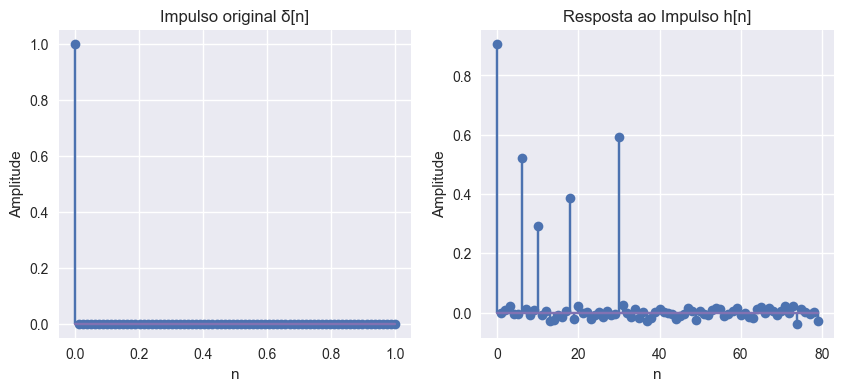

In [8]:
h_n = AWGN_MPChannel(atenuacoes, atrasos, comprimento, snr_db)
n_h = np.arange(len(h_n))   # Reposta ao impulso do sistema

fig, axs = plt.subplots(1, 2, figsize=(10,4))

# Impulso original
axs[0].stem(n_convolution, delta_n)
axs[0].set_title('Impulso original δ[n]')
axs[0].set_xlabel('n')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True)

# Resposta ao impulso canal AWGN com multipercursos
axs[1].stem(n_h, h_n)
axs[1].set_title('Resposta ao Impulso h[n]')
axs[1].set_xlabel('n')
axs[1].set_ylabel('Amplitude')
axs[1].grid(True)


plt.show()

### Convolução da resposta ao impulso entre degrau unitário e resposta ao impulso do canal

 Conv_sum:
   ➤ Erro Médio Quadrático (MSE): 1.684377e-32
   ➤ Correlação de Pearson:       1.000000

 Conv_sum_vectorized:
   ➤ Erro Médio Quadrático (MSE): 2.187934e-33
   ➤ Correlação de Pearson:       1.000000



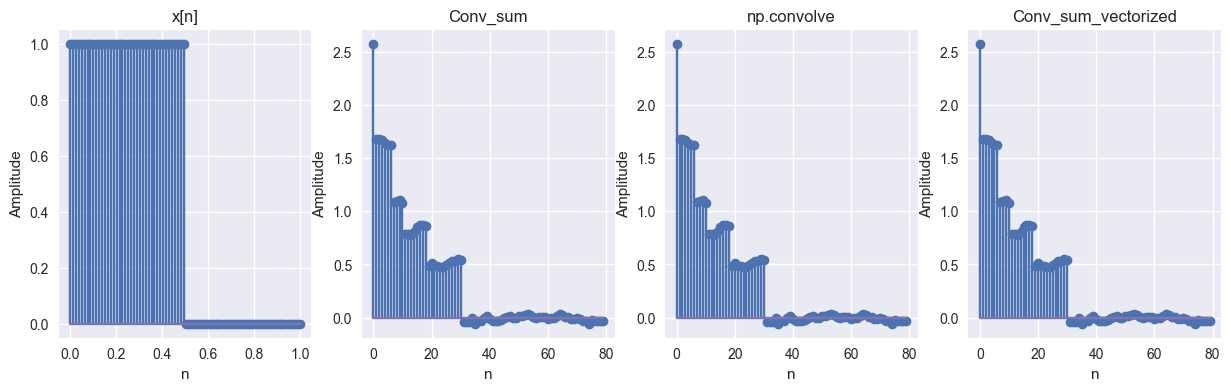

<Figure size 800x550 with 0 Axes>

In [18]:
y_n = np.convolve(degrau_n, h_n, mode='same')
y_func = Conv_sum(degrau_n, h_n, mode='same')
y_vec = Conv_sum_vectorized(degrau_n, h_n, mode='same')

n_results = np.arange(len(y_func))

Num_validate(y_n, y_func, "Conv_sum")
Num_validate(y_n, y_vec, "Conv_sum_vectorized")


# plotando os resultados
fig, axs = plt.subplots(1,4,figsize=(15, 4))
axs[0].stem(n_convolution, degrau_n)
axs[0].set_title('x[n]')
axs[0].set_xlabel('n')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True)

axs[1].stem(n_results, y_func)
axs[1].set_title('Conv_sum')
axs[1].set_xlabel('n')
axs[1].set_ylabel('Amplitude')
axs[1].grid(True)

axs[2].stem(n_results, y_n)
axs[2].set_title('np.convolve')
axs[2].set_xlabel('n')
axs[2].set_ylabel('Amplitude')
axs[2].grid(True)

axs[3].stem(n_results, y_vec)
axs[3].set_title('Conv_sum_vectorized')
axs[3].set_xlabel('n')
axs[3].set_ylabel('Amplitude')
axs[3].grid(True)

plt.show()
plt.tight_layout()

---

Os resultados numéricos e gráfico mostram que ambas as funções de convolução, em laço e vetorizada retornam os mesmos valores que a função *np.convolve*, uma função já conhecida. O sinal utilizado para teste possui fatores de geração aleatória, de modo que torna o teste robusto e pode ser usado como argumento de validação.

<a id="32-complexidade-computacional"></a>
## 3.2 Complexidade computacional

### Geração dos tempos de execução e ilustração gráfica comparativa

In [ ]:
# Vetores para acúmulo das médias calculadas
times_py = []
times_vectorized = []
times_numba_par = []
times_gpu = []
times_cupy = []
times_numpy = []

for N in sizes:
    x = np.random.rand(N)
    h = np.random.rand(N)
    t_py = []
    t_vec = []
    t_nbP = []
    t_gpu = []
    t_cp = []
    t_np = []

    for _ in range(rep):

        # Python laço
        start = time.time()
        Conv_sum(x, h, mode="full")
        t_py.append(time.time() - start)

        # Python vetorizado
        start = time.time()
        Conv_sum_vectorized(x, h, mode="full")
        t_vec.append(time.time() - start)

        # Numba com  laço
        start = time.time()
        Conv_sum_numba_parallel(x, h, mode="full")
        t_nbP.append(time.time() - start)

        # Cálculo vetorizado rodando em GPU
        start = time.time()
        Conv_sum_gpu(x, h, mode="full")
        t_gpu.append(time.time() - start)

        # cp.convolve
        start = time.time()
        Conv_sum_cupy(x, h, mode="full")
        t_cp.append(time.time() - start)

        # np.convolve
        start = time.time()
        np.convolve(x, h, mode="full")
        t_np.append(time.time() - start)
    
    times_py.append(np.mean(t_py))
    times_vectorized.append(np.mean(t_vec))
    times_numba_par.append(np.mean(t_nbP))
    times_gpu.append(np.mean(t_gpu))
    times_cupy.append(np.mean(t_cp))
    times_numpy.append(np.mean(t_np))

idxs = [0, -1]

for idx in idxs:
    n = sizes[idx]

    print(f"\nTempo de execução para N = {n}:")
    print(f"  Python puro:             {times_py[idx]:.6f} s")
    print(f"  Convolução Vetorizada:   {times_vectorized[idx]:.6f} s")
    print(f"  Numba (parallel=True):   {times_numba_par[idx]:.6f} s")
    print(f"  Numba (vetorizado):      {times_gpu[idx]:.6f} s")
    print(f"  CuPy:                    {times_cupy[idx]:.6f} s")
    print(f"  NumPy:                   {times_numpy[idx]:.6f} s")

plt.figure(figsize=(8,5))
plt.plot(sizes, times_py, 'o-', label="Convolução em laço")
plt.plot(sizes, times_vectorized, '^-', label="Convolução Vetorizada")
plt.plot(sizes, times_numba_par, 'd-', label="Convolução com Numba")
plt.plot(sizes, times_gpu, 'p-', label="Convolução em GPU")
plt.plot(sizes, times_cupy, 's-', label="Função CuPy")
plt.plot(sizes, times_numpy, 'x-', label="Função NumPy")
plt.xlabel("Tamanho do sinal N")
plt.ylabel("Tempo (s)")
plt.title("Tempo de execução da convolução (full)")
plt.legend()
plt.grid(True)
plt.show()

---

Com base nos valores obtidos e no gráfico, pode-se concluir que o tempo de processamento das funções implementadas, sem a utilização de métodos para aceleração de código, após um certo número de amostras, apresentam um tempo de execução muito maior que as funções já conhecidas do *numpy* e *cupy*, e que as funções aceleradas usando *numba* e *cupy*.

É valido notar que o tempo de processamento da função veorizada é, em geral, menor que a função em laço, mas ainda assim, a diferença com os métodos otimizados é gritante.

Note que a primeira execução da função com o decorador *numba* teve um alto tempo de execução, devido à compilação do código em tempo de execução realizado pelo *Numba* na primeira chamada da função. Após a primeira chamada, as funções já são executadas a partir do código compilado.

<a id="33-equações-de-diferenças"></a>
## 3.3 Equações de diferenças

### Resposta ao impulso da equação de diferenças


 pyfilter:
   ➤ Erro Médio Quadrático (MSE): 0.000000e+00
   ➤ Correlação de Pearson:       1.000000



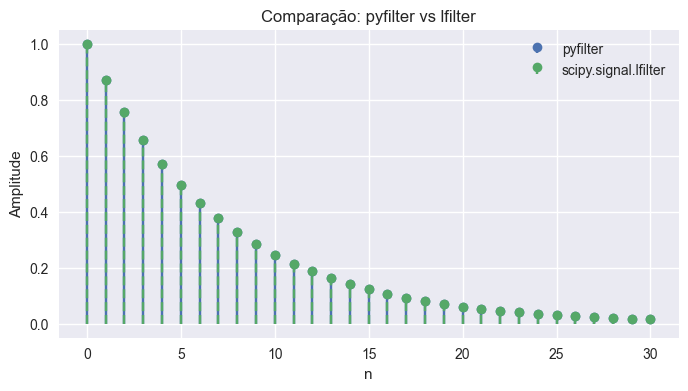

In [23]:
y_pyfilter = pyfilter(b, a, x_difeq)
y_scipy = lfilter(b, a, x_difeq)

# Comparação numérica
Num_validate(y_scipy, y_pyfilter, "pyfilter")

# Plot comparativo
plt.figure(figsize=(8,4))
plt.stem(y_pyfilter, linefmt='C0-', markerfmt='C0o', basefmt=" ", label='pyfilter')
plt.stem(y_scipy, linefmt='C1--', markerfmt='C1o', basefmt=" ", label='scipy.signal.lfilter')
plt.xlabel('n')
plt.ylabel('Amplitude')
plt.title('Comparação: pyfilter vs lfilter')
plt.legend()
plt.grid(True)
plt.show()

---

É possível notar no gráfico que a resposta ao impulso gerada pela função *pyfilter* é equivalente à gerada pela função *lfilter*, e está de acordo com os resultados obtidos no experimento da bibliografia

<a id="34-amostragem-de-sinais-contínuos-no-tempo"></a>
## 3.4 Amostragem de sinais contínuos no tempo

### Gráfico comparativo entre sinais contínuos e sinais amostrados a 10 Hz, e espectro dos sinais amostrados

In [ ]:
plt.figure(figsize=(10, 4))

fig, axs = plt.subplots(2, 2, figsize=(12, 5))

axs[0,0].plot(t_total3, x_original, label='Sinal contínuo', color = 'gray')
stem1 = axs[0,0].stem(t3, x)
plt.setp(stem1.markerline, color='black')
plt.setp(stem1.stemlines, color='black')
plt.setp(stem1.baseline, color='black')
axs[0,0].set_title('x[n]')
axs[0,0].set_xlabel('n')
axs[0,0].set_ylabel('Amplitude')
axs[0,0].grid(True)

# Segundo subplot
axs[0,1].plot(t_total7, x_2_original, label='Sinal contínuo', color = 'gray')
stem2 = axs[0,1].stem(t7, x_2)
plt.setp(stem2.markerline, color='black')
plt.setp(stem2.stemlines, color='black')
plt.setp(stem2.baseline, color='black')
axs[0,1].set_title('y[n] = x[n] * h[n]')
axs[0,1].set_xlabel('n')
axs[0,1].set_ylabel('Amplitude')
axs[0,1].grid(True)


X3 = np.fft.fft(x)
X7 = np.fft.fft(x_2)

# eixo de frequências original
f3 = np.fft.fftfreq(N3, d=1/fs)
f7 = np.fft.fftfreq(N7, d=1/fs)

# 4) Replicação periódica do espectro (±fs)
f_rep3  = np.hstack([f3 - fs, f3, f3 + fs])
f_rep7  = np.hstack([f7 - fs, f7, f7 + fs])
X3_rep = np.tile(np.abs(X3), 3)
X7_rep = np.tile(np.abs(X7), 3)

axs[1,0].stem(f_rep3, X3_rep, 
         linefmt='b-', markerfmt='bo', basefmt=" ",
         label='cos(2π·3t)')
axs[1,0].set_title('Espectro teórico de x[n]')
axs[1,0].set_xlabel('Frequência (Hz)')
axs[1,0].set_ylabel('Magnitude')
axs[1,0].grid(True)

axs[1,1].stem(f_rep7, X7_rep, 
         linefmt='b-', markerfmt='bo', basefmt=" ",
         label='cos(2π·7t)')
axs[1,1].set_title('Espectro teórico de y[n]')
axs[1,1].set_xlabel('Frequência (Hz)')
axs[1,1].set_ylabel('Magnitude')
axs[1,1].grid(True)

plt.tight_layout()
plt.show()

---

É possível notar a partir da análise dos gráficos, que ambos os sinais amostrados possuem o mesmo espectro. Isso ocorre porque a extremidade esquerda da cópia do espectro do $cos(2\pi 7 t)$,  centrada na frequência $f_s$, posicionada em: $\Omega = 10 - 7 = 3$ está à esquerda da extremidade direita do espectro do sinal original centrada em 0, pois $0+7 = 7$. Isso significa que há sobreposião os espectros, e que quando tentarmos recuperar os sinais a partir do uso de um filtro passa-baixas, não será possível obter o sinal $cos(2 \pi 7 t)$. 

Esse comportamento é esperado, uma vez que a frequência mínima para amostragem de um sinal cuja frequência máxima é $7 \mathrm{Hz}$

### Recuperação dos sinais obtidos a partir do filtro idealizado usando interpolação

In [ ]:
# Módulo da resposta em frequência teórica dos filtros passa-baixas ideais para f_c = 4 Hz
H3 = np.where(np.abs(f_rep3) <= f04, 1, 0)
H7 = np.where(np.abs(f_rep7) <= f04, 1, 0)

Y3 = X3_rep * H3
Y7 = X7_rep * H7

fig, axs = plt.subplots(3, 2, figsize=(13, 10))

axs[0,0].stem(f_rep3, Y3, label='Resposta em frequência para f_c = 3Hz')
axs[0,0].setxlim(-5, 5)
axs[0,0].set_title('Resposta em frequência de cos(2π·3·t)')
axs[0,0].set_xlabel('Frequência (Hz)')
axs[0,0].set_ylabel('Magnitude')
axs[0,0].grid(True)

axs[0,1].stem(f_rep7, Y7, label='Resposta em frequência para f_c = 7Hz')
axs[0,1].setxlim(-5, 5)
axs[0,1].set_title('Resposta em frequência de cos(2π·7·t)')
axs[0,1].set_xlabel('Frequência (Hz)')
axs[0,1].set_ylabel('Magnitude')
axs[0,1].grid(True)

x_rec = np.zeros_like(t_total3)
x2_rec = np.zeros_like(t_total7)


for n in range(N3):
    x_h = x[n] * np.sinc(fs*(t_total3 - n/fs))


    axs[1,0].plot(t_total3, x_h, label=f'x[n={n}]')
    axs[1,0].stem(t3, x)

    x_rec += x_h
    
for i in range(N7):
    x2_h = x_2[i] * np.sinc(fs*(t_total7 - i/fs))
    axs[1,1].plot(t_total7, x2_h, label=f'y[n={i}]')
    axs[1,1].stem(t7, x_2)

    x2_rec += x2_h



axs[1,0].set_title('Sinal x[n] filtrado')
axs[1,0].set_xlabel('Tempo (s)')
axs[1,0].set_ylabel('Amplitude')
axs[1,0].grid(True)

axs[1,1].set_title('Sinal y[n] filtrado')
axs[1,1].set_xlabel('Tempo (s)')
axs[1,1].set_ylabel('Amplitude')
axs[1,1].grid(True)

axs[2,0].plot(t_total3, x_original, label=f'x[n={n}]')
axs[2,0].plot(t_total3, x_rec, label='Sinal reconstruído cos(2π·3·t)')
axs[2,0].set_title('Sinal reconstruído cos(2π·3·t)')
axs[2,0].set_xlabel('Tempo (s)')
axs[2,0].set_ylabel('Amplitude')
axs[2,0].grid(True)

axs[2,1].plot(t_total7, x_2_original, label=f'y[n={n}]')
axs[2,1].plot(t_total7, x2_rec, label='Sinal reconstruído cos(2π·7·t)')
axs[2,1].set_title('Sinal reconstruído cos(2π·7·t)')
axs[2,1].set_xlabel('Tempo (s)')
axs[2,1].set_ylabel('Amplitude')
axs[2,1].grid(True)
fig.tight_layout(pad=2.0)

---

Pode-se notar pelo gráfico na primeira linha da imagem, que o módulo do espectro obtido com um filtro idealizado com frequência de corte de $4 \mathrm{Hz}$ é representado por impulsos na frequência de $3 \mathrm{Hz}$. Isso significa que o sinal amostrado recuperado a partir da filtragem idealizada é o mesmo para ambos: $\cos(2\pi 3 t) $, amostrado em 10 Hz. Esse comportamento mostra que, com uma frequência de amostragem de $10 \mathrm{Hz}$, é possível recuperar o sinal discretizado de $3 \mathrm{Hz}$, mas não o de $7 \mathrm{Hz}$.

São mostradas na segunda linha da imagem os gráficos com as componentes sinc dos sinais discretos recuperados, e na terceira linha, os gráficos com o resultado da interpolação resultante da soma das funções sinc. Como esperado, o sinal contínuo recuperado para ambos os casos é uma senoide a $3 \mathrm{Hz}$.

É possível recuperar o sinal de $7 \mathrm{Hz}$ aumentando a frequência de amostragem utilizada no experimento para além da frequência mínima para este caso, que seria de $2*7 = $14 \mathrm{Hz}$$.

<a id="35-ruído-aditivo-gaussiano-branco"></a>
## 3.5 Ruído aditivo gaussiano branco

### Gráfico sinal limpo e ruidoso

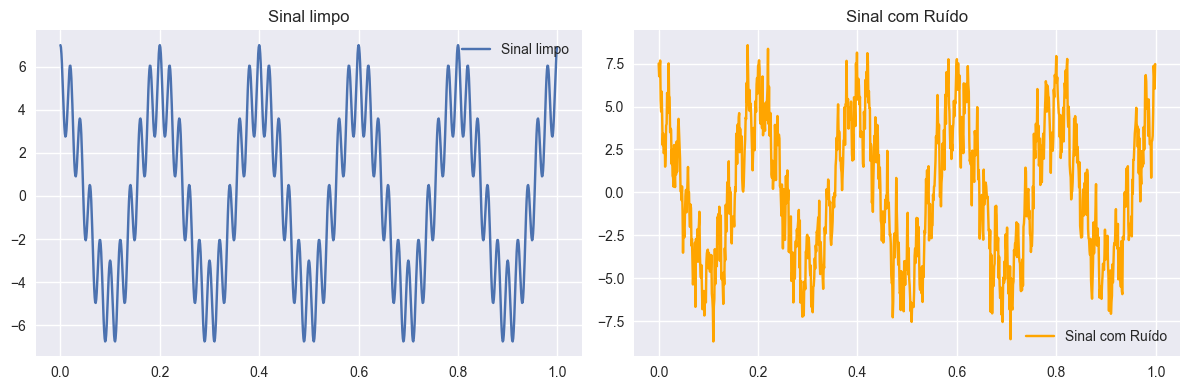

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(t_exp3, x_t, label='Sinal limpo')
axs[0].set_title('Sinal limpo')
axs[0].legend()

axs[1].plot(t_exp3, x_noise, label='Sinal com Ruído', color='orange')
axs[1].set_title('Sinal com Ruído')
axs[1].legend()

plt.tight_layout()
plt.show()

### Geração dos gráficos comparativos entre sinal limpo e filtrado

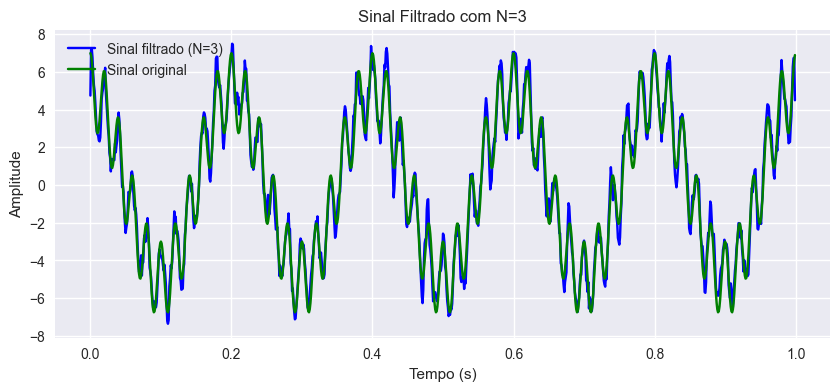

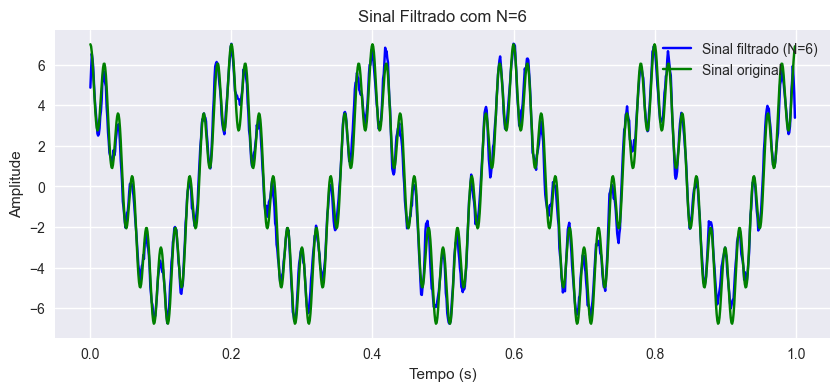

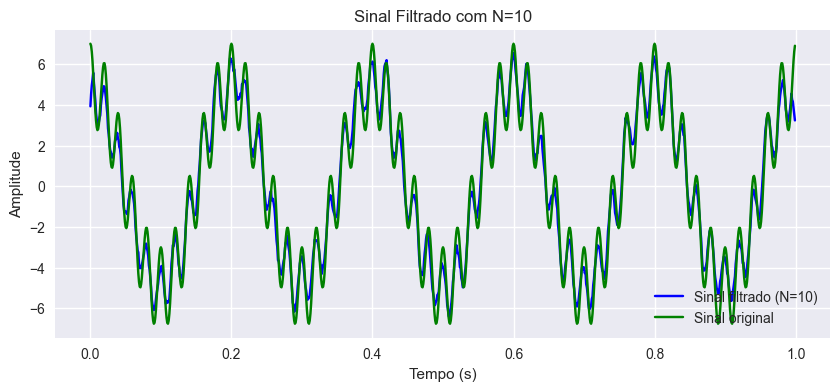

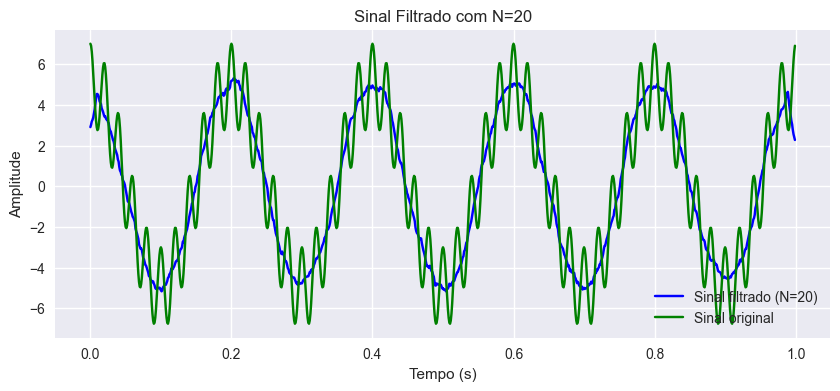

In [10]:
for n in N_exp3:
    delta_exp3 = np.r_[1, np.zeros(n)]
    b_exp3 = [1/n] * n  # Coeficientes b_k do filtro FIR para média móvel
    h_n_exp3 = pyfilter(b_exp3, a_exp3, delta_exp3)  # Resposta ao impulso do filtro FIR

    y_exp3 = Conv_sum_vectorized(x_noise, h_n_exp3, mode='same') # Sinal filtrado

    plt.figure(figsize=(10, 4))
    plt.plot(t_exp3, y_exp3, label=f'Sinal filtrado (N={n})', color='blue')
    plt.plot(t_exp3, x_t, label='Sinal original', color='green')
    plt.title(f'Sinal Filtrado com N={n}')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()


---

Analisando os gráficos, nota-se que esse filtro é bastante eficaz em retirar a influência do ruído aleatório, no entanto, ao aumentar demais a ordem do filtro, praticamente eliminou-se a componente de maior frequência do sinal. para entender esse comportamento, pode-se analisar a resposta em frequência desse filtro.

### Módulo do espectro dos sinais e da resposta em frequência do filtro média móvel

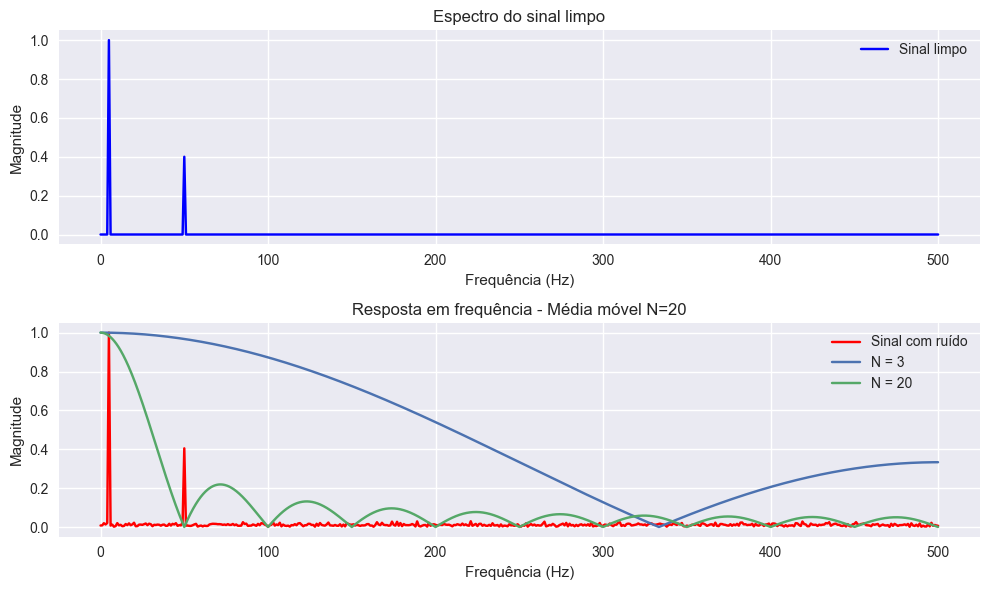

In [12]:
freqs_clean, fft_clean = compute_fft(x_t, fs_exp3)
freqs_noise, fft_noise = compute_fft(x_noise, fs_exp3)

# Gráfico dos espectros
fig1, axs1 = plt.subplots(2, 1, figsize=(10, 6))
axs1[0].plot(freqs_clean, fft_clean/np.max(fft_clean), color='blue', label = 'Sinal limpo')
axs1[0].set_title('Espectro do sinal limpo')
axs1[0].set_xlabel('Frequência (Hz)')
axs1[0].set_ylabel('Magnitude')
axs1[0].legend()

axs1[1].plot(freqs_noise, fft_noise/np.max(fft_noise), color='red', label = 'Sinal com ruído')
axs1[1].set_title('Espectro do sinal com ruído')
axs1[1].set_xlabel('Frequência (Hz)')
axs1[1].set_ylabel('Magnitude')
axs1[1].legend()

# Resposta em frequência dos filtros média móvel
N_values = [3, 20]

for i, N in enumerate(N_values):
    b_exp3 = np.ones(N) / N
    w, h = freqz(b_exp3, worN=8000)
    axs1[1].plot((fs_exp3 * 0.5 / np.pi) * w, np.abs(h), label=f'N = {N}')
    axs1[1].set_title(f'Resposta em frequência - Média móvel N={N}')
    axs1[1].set_xlabel('Frequência (Hz)')
    axs1[1].set_ylabel('Magnitude')
    axs1[1].legend()

plt.tight_layout()
plt.show()

---

É possível notar pela análise dos gráficos o filtro média móvel se trata de um filtro passa-baixas, e que quanto maior o $N$, mais estreita é a faixa de passagem, me modo que, para $N = 20$, frequências maiores que $25 \mathrm{Hz}$ já estão atenuadas em mais de 50%. Note que em $50 \mathrm{Hz}$m há um nulo na resposta em frequência, o que justifica a perda da componente em alta frequêcnia do sinal analisado

<a id="conclusao"></a>
# Conclusão

